# Developing an Explainable AI Tool to Support Breast Cancer Diagnosis
Advanced Seminar Operations & Technology Management (WIHN0034): Business Analytics and its Application in Healthcare

Instructor: Prof. Jingui Xie 


# Libraries

In [4]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap 

## Preprocessing 

In [5]:
# load dataset (without columns)
df = pd.read_csv("wdbc.data", header=None) 

# Column names based on wdbc.names
columns = [
    'ID', 'Diagnosis',
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
df.columns = columns

print(df.head())
print(df.shape)
print(df.dtypes)
print(df["Diagnosis"].value_counts())


         ID Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

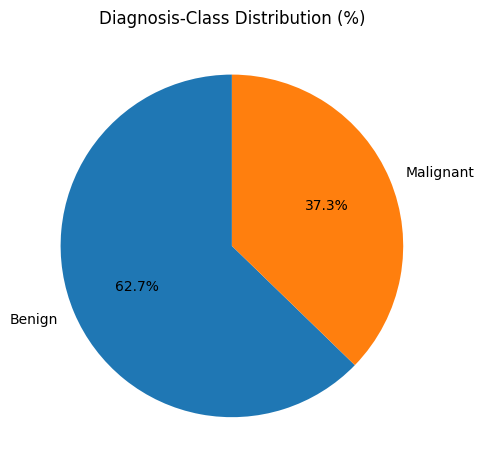

In [6]:
# Vizualizing class dristibution
class_counts = df["Diagnosis"].value_counts()

plt.figure(figsize=(5, 5))
class_counts.plot(
    kind="pie",
    autopct="%.1f%%",
    startangle=90,
    labels=["Benign", "Malignant"]
)
plt.ylabel("")
plt.title("Diagnosis-Class Distribution (%)")
plt.tight_layout()
plt.show()



In [7]:
# checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

# checking for duplicates
duplicates_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

ID                         0
Diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64
Number of duplicate rows: 0


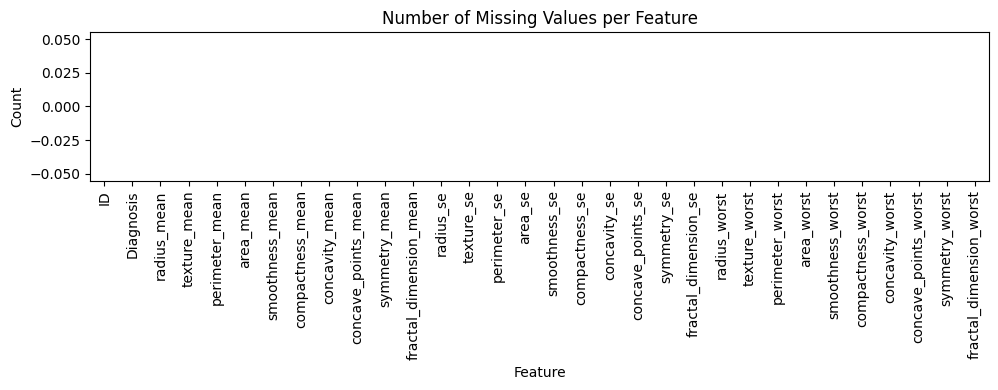

In [8]:
plt.figure(figsize=(10, 4))
missing_values.plot(kind="bar")
plt.title("Number of Missing Values per Feature")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [9]:
# Checking unique values 
print(df["Diagnosis"].unique())

# Encoding target variable
df["Diagnosis"] = df["Diagnosis"].map({"B": 0, "M": 1})

df["Diagnosis"].value_counts()

['M' 'B']


Diagnosis
0    357
1    212
Name: count, dtype: int64

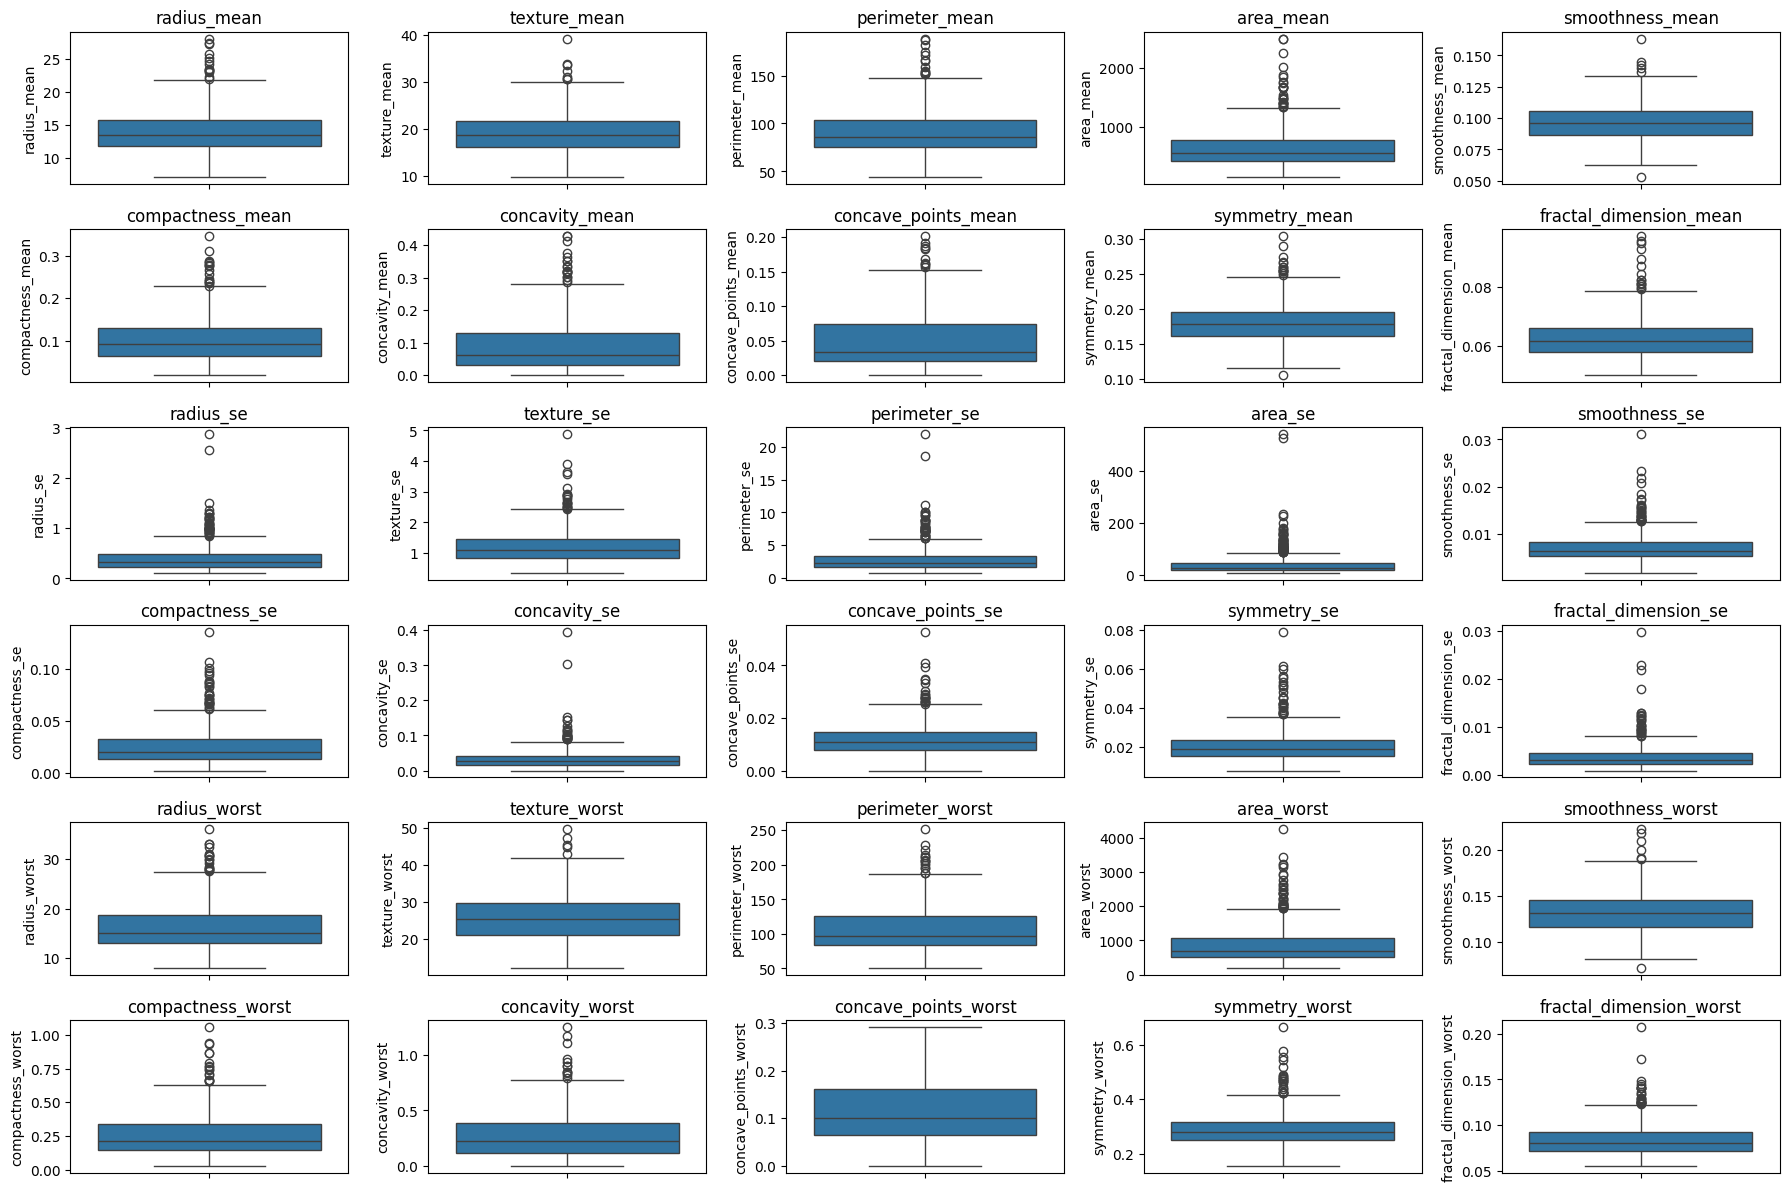

In [10]:
# Outlier detection

features = df.drop(columns=["ID", "Diagnosis"]).columns

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(y=df[feature], ax=axes[i])
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

<span style="color: orange;">Findings:</span>

Although several features show extreme values, these are biologically plausible and strongly associated with malignant cases.
Removing such observations would distort the clinical meaning of the dataset and potentially reduce diagnostic performance.
Therefore, no outlier removal was applied.

In [11]:
# Dropping ID column since it is not important for analysis

df = df.drop(columns=["ID"])

<span style="color: orange;">Findings:</span>

The dataset is clean, complete and does not require imputation or correction. 

### Train-Test-Splitting & Scaler

In [12]:
# Feature / Target split
X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<span style="color: orange;">Findings:</span>

Before training any model, we explicitly separate input features from the target variable to avoid information leakage.
The dataset is then split into training and test sets, ensuring that model evaluation reflects real-world generalization and to reduce overfitting.

Features were standardized using z-score normalization to ensure comparable scales across variables.
Scaling was applied only to models sensitive to feature magnitudes, such as Logistic Regression and SVM.

## Model Training

### Logistic Regression

In [13]:
# Initialize model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train model
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.9649122807017544
Precision: 0.975
Recall: 0.9285714285714286
F1 Score: 0.9512195121951219
ROC-AUC: 0.996031746031746


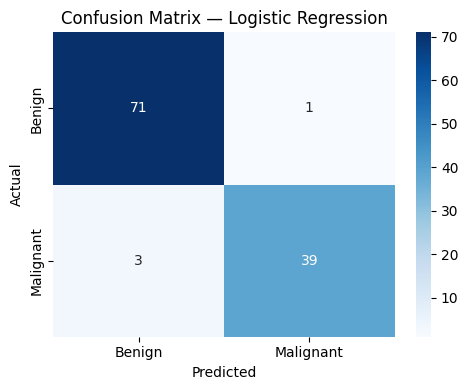

In [14]:
# Vizualizing Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()

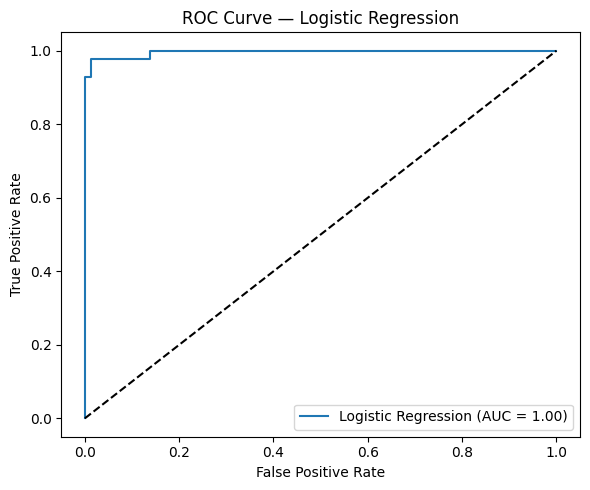

In [15]:
# Vizualizing ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

<span style="color: orange;">Findings:</span>

Logistic Regression shows excellent performance and strong sensitivity, making it a solid and interpretable baseline.

### Support Vector Machine (SVM)

In [16]:
# Linear SVM
# Initialize model
svm_model = SVC(kernel="linear", probability=True, random_state=42)

# Train model
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_svm))

Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9047619047619048
F1 Score: 0.95
ROC-AUC: 0.9914021164021164


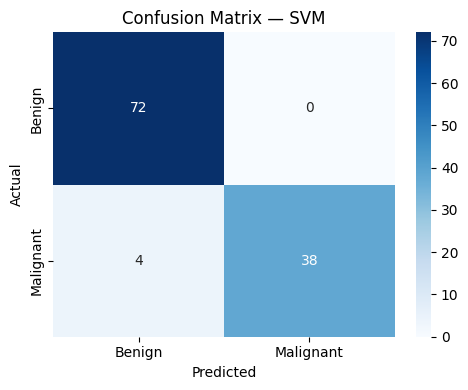

In [17]:
# Vizualizing Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — SVM")
plt.tight_layout()
plt.show()

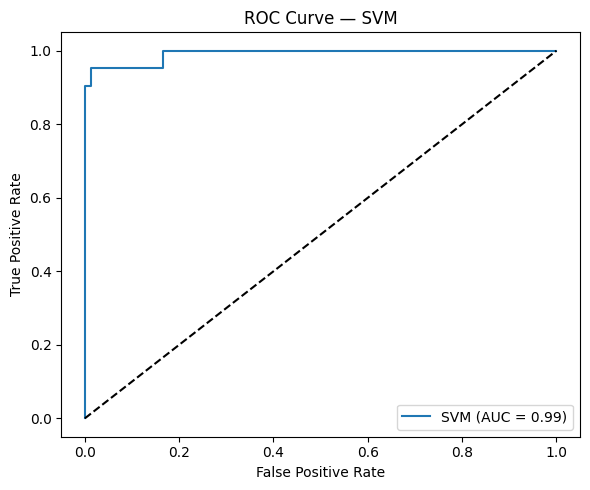

In [18]:
# Vizualizing ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_score(y_test, y_pred_proba_svm):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — SVM")
plt.legend()
plt.tight_layout()
plt.show()

<span style="color: orange;">Findings:</span>

SVM focuses on critical boundary cases rather than all observations, which can be advantageous in medical classification tasks involving borderline samples.

The SVM achieves excellent overall performance with a ROC-AUC close to 1.0.
However, despite perfect precision, several malignant cases are misclassified as benign

### Random Forest

In [19]:
# Initialize model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")

# Train model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_rf))

Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9047619047619048
F1 Score: 0.95
ROC-AUC: 0.996031746031746


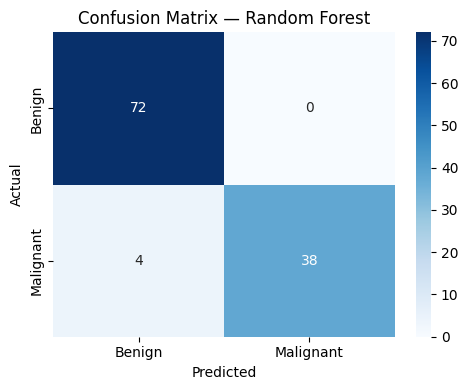

In [20]:
# Vizualizing Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()

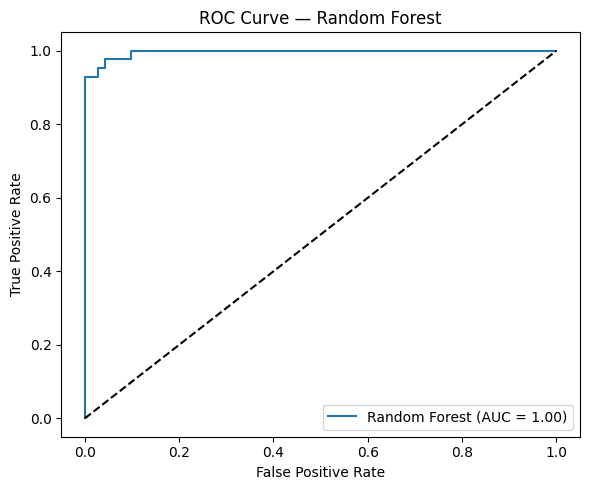

In [21]:
# Vizualizing ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

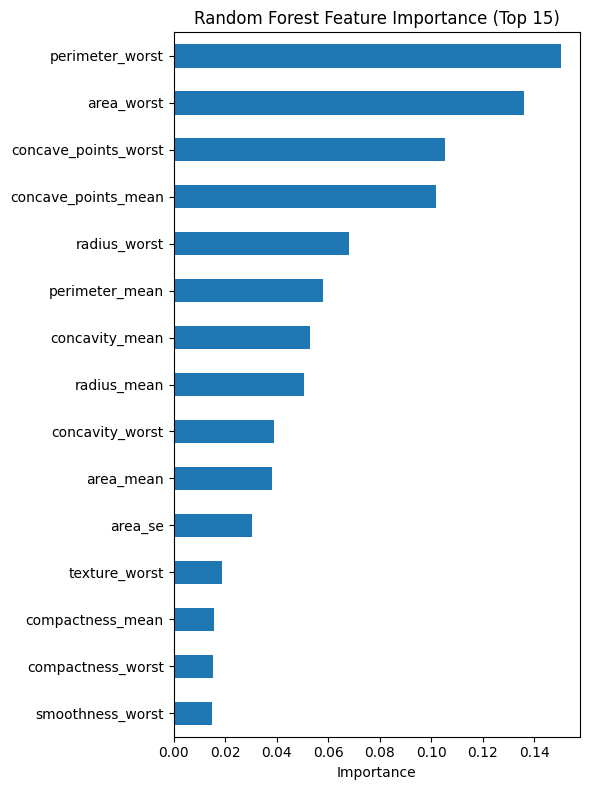

In [22]:
# Vizualizing Feature Importance
importances = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(6, 8))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

<span style="color: orange;">Findings:</span>

Random Forest performs strongly and highlights clinically relevant features, but does not outperform Logistic Regression in sensitivity

### XGBoost

In [23]:
# Initialize model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))

Accuracy: 0.9736842105263158
Precision: 1.0
Recall: 0.9285714285714286
F1 Score: 0.9629629629629629
ROC-AUC: 0.9953703703703705


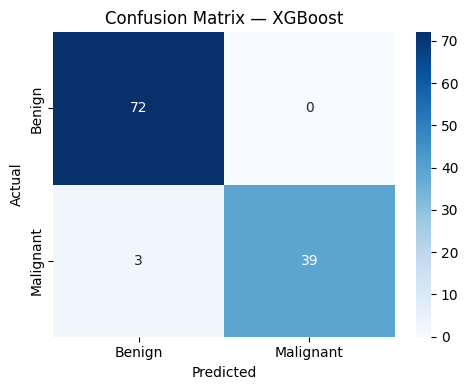

In [24]:
# Vizualizing Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — XGBoost")
plt.tight_layout()
plt.show()

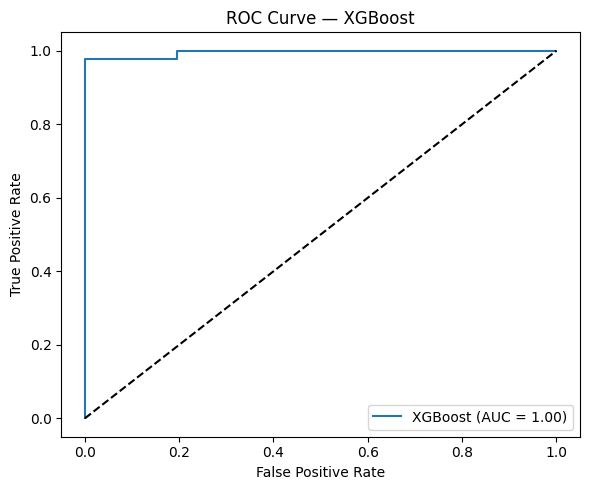

In [25]:
# Vizualizing ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(6, 5))
plt.plot(
    fpr_xgb,
    tpr_xgb,
    label=f"XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.2f})"
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

<span style="color: orange;">Findings:</span>

XGBoost achieved the best overall performance, combining high sensitivity with perfect precision.

In [26]:
# Hyperparameter tuning for XGBoost

# Set up the base model
xgb_base = XGBClassifier(eval_metric="logloss", random_state=42)

param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [2, 3, 4, 5],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3, 0.5]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,              # ausreichend bei kleinem Datensatz
    scoring="recall",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Best parameters + model
print("Best Recall (CV):", random_search.best_score_)
print("Best Params:\n", random_search.best_params_)

best_xgb = random_search.best_estimator_

# Evaluation of the best model on the test set
y_pred_best = best_xgb.predict(X_test)
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

print("Tuned XGBoost — Test Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Recall (CV): 0.9529411764705882
Best Params:
 {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}
Tuned XGBoost — Test Performance
Accuracy: 0.9736842105263158
Precision: 1.0
Recall: 0.9285714285714286
F1: 0.9629629629629629
ROC-AUC: 0.9927248677248677


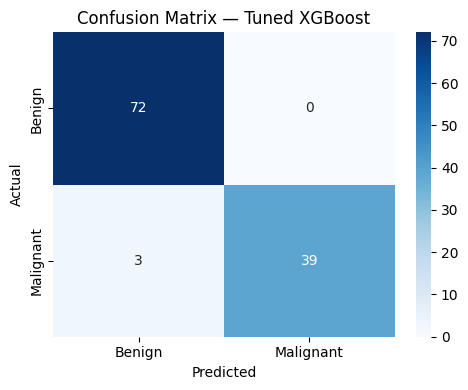

In [27]:
# Vizualizing Confusion Matrix (Tuned XGBoost)
cm_xgb_tuned = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_xgb_tuned, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Tuned XGBoost")
plt.tight_layout()
plt.show()

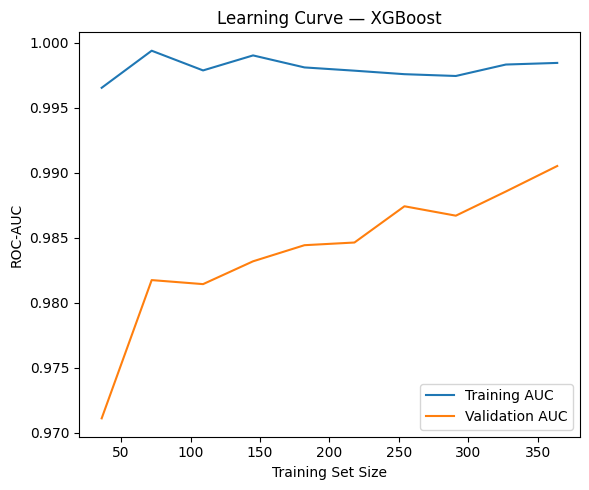

In [28]:
# Check Overfitting with Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6, 5))
plt.plot(train_sizes, train_mean, label="Training AUC")
plt.plot(train_sizes, val_mean, label="Validation AUC")
plt.xlabel("Training Set Size")
plt.ylabel("ROC-AUC")
plt.title("Learning Curve — XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

<span style="color: orange;">Findings:</span>

Hyperparameter tuning did not improve test performance, baseline XGBoost already performs near-optimally.

Why I didn't examine more models:
- naive Bayes: Excluded due to its strong feature independence assumption, which is violated by the highly correlated morphological features in the dataset.
- k-Nearest Neighbors (kNN): Excluded because it is sensitive to feature scaling, performs poorly in high-dimensional spaces, and offers limited clinical interpretability.
- Kernel-based SVM (RBF, polynomial): Excluded due to increased complexity and reduced interpretability without meaningful performance gains over linear SVM.
- Neural Networks / Deep Learning: Excluded because the dataset size is insufficient to justify deep architectures and increases the risk of overfitting.
- LightGBM: Excluded as it is optimized for large-scale datasets and does not provide clear advantages over XGBoost in this setting.

# Explainability 

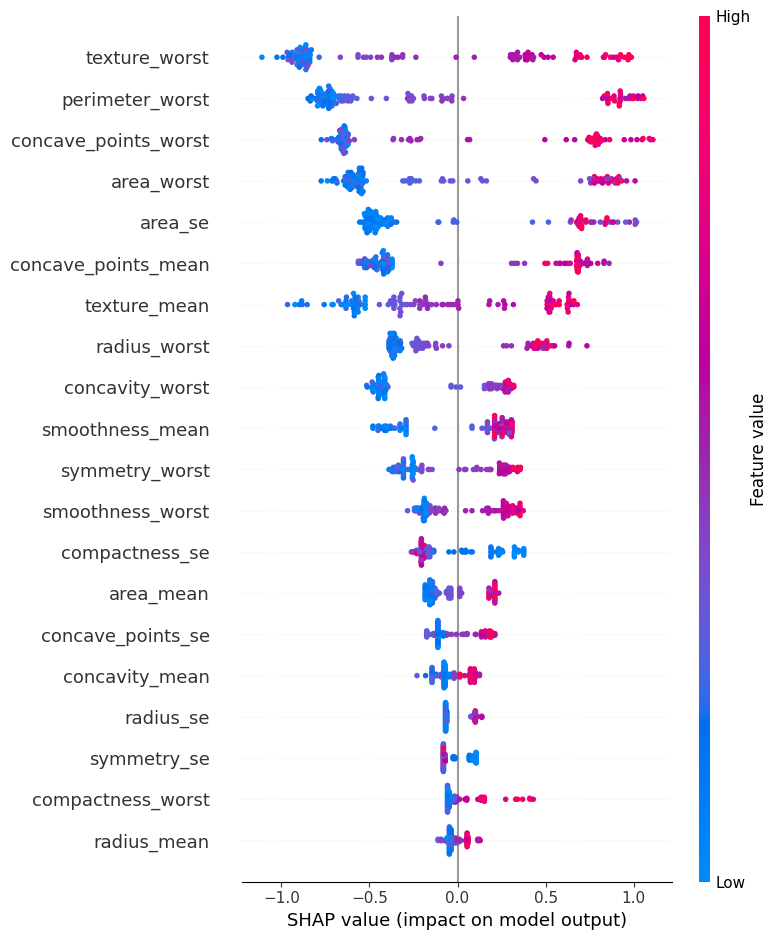

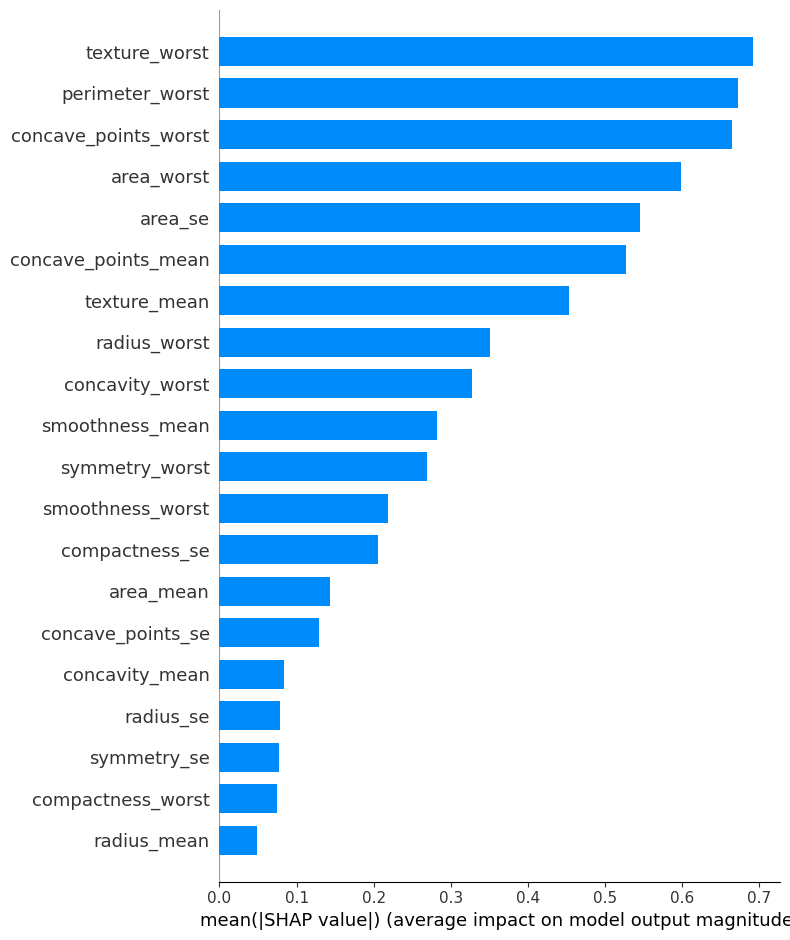

In [29]:
# SHAP for XGBoost

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_xgb)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Summary plot (global)
shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar") #bar plot

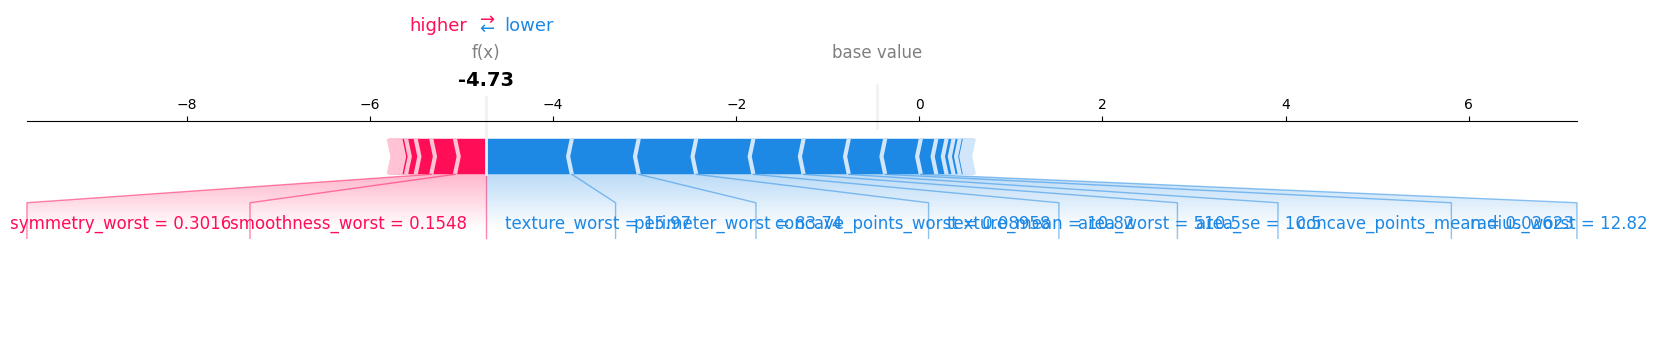

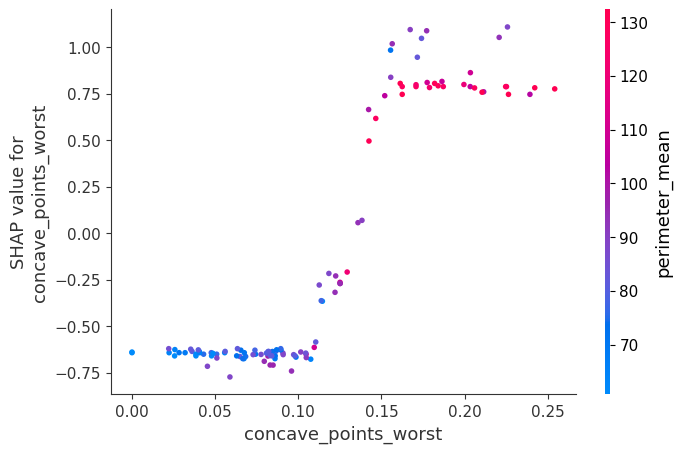

In [34]:
# Local Explainability for first test instance
i = 0  # index of patient
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test.iloc[i],
    matplotlib=True
)

# Dependence plot
shap.dependence_plot(
    "concave_points_worst",
    shap_values,
    X_test
)


# Save model

In [237]:
'''
import os
import pickle
    
with open("CellSight/xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

with open("CellSight/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
'''

'\nimport os\nimport pickle\n\nwith open("CellSight/xgb_model.pkl", "wb") as f:\n    pickle.dump(best_xgb, f)\n\nwith open("CellSight/scaler.pkl", "wb") as f:\n    pickle.dump(scaler, f)\n'

# Model Deployment

Prediction: Malignant
Model risk assessment: High risk (score=0.90)


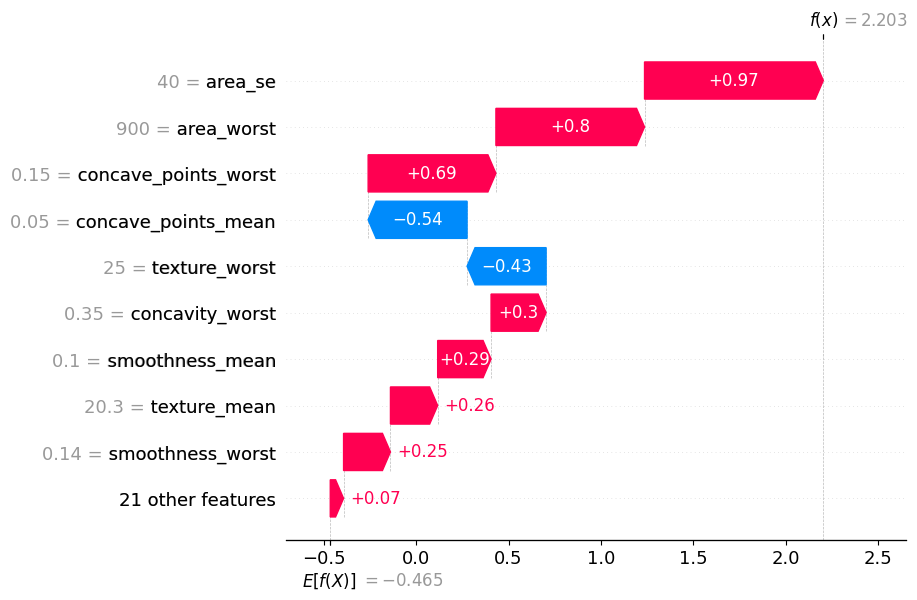

In [238]:
# Define a single patient manually
patient_dict = {
    "radius_mean": 14.5,
    "texture_mean": 20.3,
    "perimeter_mean": 95.2,
    "area_mean": 700.0,
    "smoothness_mean": 0.10,
    "compactness_mean": 0.12,
    "concavity_mean": 0.08,
    "concave_points_mean": 0.05,
    "symmetry_mean": 0.18,
    "fractal_dimension_mean": 0.06,
    "radius_se": 0.40,
    "texture_se": 1.20,
    "perimeter_se": 3.0,
    "area_se": 40.0,
    "smoothness_se": 0.007,
    "compactness_se": 0.020,
    "concavity_se": 0.030,
    "concave_points_se": 0.015,
    "symmetry_se": 0.020,
    "fractal_dimension_se": 0.003,
    "radius_worst": 16.0,
    "texture_worst": 25.0,
    "perimeter_worst": 110.0,
    "area_worst": 900.0,
    "smoothness_worst": 0.14,
    "compactness_worst": 0.30,
    "concavity_worst": 0.35,
    "concave_points_worst": 0.15,
    "symmetry_worst": 0.30,
    "fractal_dimension_worst": 0.09,
}

patient_df = pd.DataFrame([patient_dict])
patient_df = patient_df[X_train.columns].astype(float)

pred = best_xgb.predict(patient_df)[0]
prob = best_xgb.predict_proba(patient_df)[0, 1]

label = "Malignant" if pred == 1 else "Benign"
print(f"Prediction: {label}")
if prob >= 0.75:
    risk = "High risk"
elif prob >= 0.4:
    risk = "Moderate risk"
else:
    risk = "Low risk"

print(f"Model risk assessment: {risk} (score={prob:.2f})")

# SHAP explanation for the single patient
shap_values = explainer(patient_df)
shap.plots.waterfall(shap_values[0])
